In [2]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.impute import SimpleImputer
import matplotlib as mpl

# Parameters
file_path = Path("/Users/olesi/Desktop/Codes/Files/joints_processed_final.xlsx")
turns = ["Turn1", "Turn4", "Turn5", "Turn6", "Turn7", "Turn8"] # List of turns in the downhill course
marker_col = "Marker"
time_col = "time"
activity_col = "Activity"

In [3]:
"""
Load the Excel file containing the sensor data and print the number of available sheets.
Each sheet corresponds to one run.
"""

xls = pd.ExcelFile(file_path)
data = {sheet: xls.parse(sheet) for sheet in xls.sheet_names} # Dictionary mapping each run name to its corresponding DataFrame of sensor data
print("There are", len(data), "available sheets")

There are 38 available sheets


In [22]:
"""
Extract and resample a turn segment to a fixed number of points (same across all runs), which is essential for PCA analysis.
The function returns a DataFrame containing the resampled signals.
"""

def get_resampled_turn_segment(df, turn_name, marker_col="Marker", time_col="time", columns_to_use=None, target_length=None):
    start_idx = df[df[marker_col] == f"{turn_name} start"].index  # Starting index of the turn
    end_idx = df[df[marker_col] == f"{turn_name} finish"].index  # Ending index of the turn
    if start_idx.empty or end_idx.empty:
        return None  # Return None if either marker is missing

    segment = df.loc[start_idx[0]:end_idx[0]]  # Extract the segment between the two markers
    time_vals = segment[time_col].values  # Extract time values for interpolation
    if target_length is None:
        target_length = len(segment)  # Use original segment length if not specified

    interp_data = {}  # Dictionary to hold interpolated signal values
    for col in df.columns:
        if col not in [time_col, marker_col, activity_col] and (columns_to_use is None or col in columns_to_use):
            original = segment[col].dropna().values  # Get original signal values (excluding NaNs)
            if len(original) < 2:
                continue  # Skip interpolation if not enough points
            interp_func = interp1d(np.linspace(0, 1, len(original)), original, kind='linear', fill_value="extrapolate")  # Create interpolation function
            interp_data[col] = interp_func(np.linspace(0, 1, target_length))  # Interpolate to fixed length

    return pd.DataFrame(interp_data)


In [23]:
"""
Extract and resample each turn in all runs to a fixed number of points.
The resampling ensures uniform signal length across runs, which is essential for analyses like PCA.

The function returns:
- a dictionary mapping each turn to a list of resampled DataFrames (one per run)
- a dictionary mapping each turn to the corresponding list of run names
"""

def extract_turns(data, turns):
    turn_data = {turn: [] for turn in turns}  # Store resampled DataFrames for each turn
    turn_run_names = {turn: [] for turn in turns}  # Store corresponding run names for each turn
    min_lengths = {}  # Store the minimum segment length found for each turn (used as the resampling target)

    # Step 1: Determine the minimum segment length for each turn
    for turn in turns:
        lengths = []
        for run_name, df in data.items():
            start_idx = df[df[marker_col] == f"{turn} start"].index  # Index of start marker
            end_idx = df[df[marker_col] == f"{turn} finish"].index  # Index of end marker
            if not start_idx.empty and not end_idx.empty:
                lengths.append(end_idx[0] - start_idx[0] + 1)  # Segment length = end - start + 1
        if lengths:
            min_lengths[turn] = min(lengths)  # Use shortest valid segment as target length

    # Step 2: Extract and resample each turn segment to the target length
    for run_name, df in data.items():
        for turn in turns:
            n_points = min_lengths.get(turn)  # Retrieve the resampling length for this turn
            if n_points is None:
                continue  # Skip if no valid length was found

            resampled_df = get_resampled_turn_segment(df, turn, marker_col, time_col, target_length=n_points)
            if resampled_df is not None:
                turn_data[turn].append(resampled_df)  # Save the resampled data
                turn_run_names[turn].append(run_name)  # Save the corresponding run name

    return turn_data, turn_run_names

In [24]:
"""
Classify runs as 'slow' or 'fast' based on their duration.
Runs with a duration below or equal to the median are labeled as 'fast', while those above the median are labeled as 'slow'.
The function returns a dictionary mapping each run name to either 'fast' or 'slow'.
"""

def classify_run(all_data):
    durations = {}  # Dictionary to store the duration of each run

    for run, df in all_data.items():
        start = df[df[marker_col] == "Start"][time_col]  # Get the timestamp of the 'Start' marker
        stop = df[df[marker_col] == "Stop"][time_col]    # Get the timestamp of the 'Stop' marker
        if not start.empty and not stop.empty:
            durations[run] = stop.values[0] - start.values[0]  # Compute and store run duration

    median_duration = np.median(list(durations.values()))  # Compute median duration across all valid runs

    # Label each run either 'fast' if duration ≤ median or 'slow' otherwise
    run_labels = {
        run: "fast" if dur <= median_duration else "slow"
        for run, dur in durations.items()
    }

    return run_labels

# Run function
run_speed_labels = classify_run(data)

In [25]:
"""
Perform PCA on resampled turn data to explore the difference between fast and slow runs.
For each turn:
- run PCA on flattened signals
- compare explained variance of each principal component (PC) in fast vs slow runs
- identify PCs and signals that most contribute to performance differences
"""

def pca_analysis(turn_data, turn_run_names, run_labels, n_components=10, print_top_deltas=2, top_n_features=10, selected_turn=None):
    for turn, dfs in turn_data.items():  # dfs is a list of DataFrames containing the resampled signal data for each run of that specific turn
        if  selected_turn is not None and turn != selected_turn: # TO COMMENT - ALSO REMOVE SELECTED_TURN FROM FUNCTION COMPONENTS
            continue  # Skip if this is not the selected turn # TO COMMENT

        print(f"\n PCA Explained Variance per group (fast and slow) + Deltas for {turn}")
        if len(dfs) < 2:
            print(f"Not enough data for {turn}. Skipping.")
            continue

        # Prepare and align signals across runs
        excluded_keywords = [
            "Course", "Pitch", "Roll", "Activity", "time", "Marker", "Head", "Foot", "Forearm",
            "Upper", "Thigh", "Shank", "Hand", "Tilt", "Extension", "Total", "Supination"
        ]  # Keywords used to exclude non-relevant signals

        col_counts = Counter(col for df in dfs for col in df.columns)  # Count how often each column appears across all runs
        n_runs = len(dfs)  # Number of runs available for this turn

        # Keep only the columns that appear in at least 50% of runs and do not contain excluded keywords
        common_cols = sorted([
            col for col, count in col_counts.items()
            if count >= int(0.5 * n_runs)
            and not any(x in col for x in excluded_keywords)
        ])

        # Add missing columns with NaN and align column order
        for i in range(len(dfs)):
            missing_cols = set(common_cols) - set(dfs[i].columns)  # Columns present in others but missing here
            for col in missing_cols:
                dfs[i][col] = np.nan
            dfs[i] = dfs[i][common_cols]  # Reorder columns

        # Double-check filtered common columns again after NaN fill
        common_cols = sorted([
            col for col in common_cols
            if not any(x in col for x in excluded_keywords)
        ])
        dfs_aligned = [df[common_cols] for df in dfs]  # Aligned and filtered data

        # Flatten each DataFrame into a vector and assign group label ('fast' or 'slow') 
        X_all = []  # List to store flattened data
        group_labels = []  # List to store labels ('fast' or 'slow')
        for df, run_name in zip(dfs_aligned, turn_run_names[turn]):
            if run_name in run_labels:
                X_all.append(df.values.flatten())  # Convert 2D DataFrame to 1D vector
                group_labels.append(run_labels[run_name])  # Add corresponding label


        """ PCA pipeline """
        imputer = SimpleImputer(strategy="mean")  # Fill NaN values with the column mean
        X_imputed = imputer.fit_transform(X_all)  # Apply imputation to full dataset

        scaler = StandardScaler()  # Standardize data to mean 0 and standard deviation 1
        X_scaled = scaler.fit_transform(X_imputed)  # Apply scaling

        pca = PCA(n_components=n_components)  # Create PCA model
        scores = pca.fit_transform(X_scaled)  # Fit PCA and get scores (projections)

        scores = np.array(scores)  # Ensure scores is a NumPy array
        group_labels = np.array(group_labels)  # Convert labels to NumPy array for indexing

        # Separate scores by group and compute variance explained by each PC within fast and slow runs separately
        fast_scores = scores[group_labels == "fast"]
        slow_scores = scores[group_labels == "slow"]
        fast_var = np.var(fast_scores, axis=0)
        slow_var = np.var(slow_scores, axis=0)

        # Convert to percentage of total variance (normalized within group)
        fast_ratio = (fast_var / np.sum(fast_var)) * 100
        slow_ratio = (slow_var / np.sum(slow_var)) * 100
        delta = fast_ratio - slow_ratio  # Difference between groups for each PC (positive = more variance in fast)

        # Plot bar chart of explained variance per PC per group
        fig, ax = plt.subplots(figsize=(7, 4))
        x = np.arange(1, n_components + 1)
        width = 0.35

        # Bar plots
        ax.bar(x - width / 2, fast_ratio, width=width, label='Fast', color='#0080ff', alpha=0.9)
        ax.bar(x + width / 2, slow_ratio, width=width, label='Slow', color='#ff0080', alpha=0.9)

        # Axes labels with units and type (M065)
        ax.set_xlabel("Principal Component", fontsize=11)
        ax.set_ylabel("Explained Variance (%)", fontsize=11)
        ax.set_xticks(x)

        # Title will be removed as per M061 (no title, only caption)
        # ax.set_title(f"Explained Variance per Group - {turn}")  # REMOVE this

        # Grid and legend (M066)
        ax.grid(True, axis='y')
        ax.legend()

        # Centering the figure (M062)
        plt.tight_layout()

        # Save as vector graphic (Recommendation)
        plt.savefig(f"{turn}_explained_variance.svg", format='svg')  # For lossless scaling

        # Show figure
        plt.show()

        # Print top PCs with the largest difference between fast and slow
        delta_abs_sorted = sorted([(i+1, d) for i, d in enumerate(delta)], key=lambda x: abs(x[1]), reverse=True)
        print(f" Top {print_top_deltas} PCs with biggest fast vs slow difference (Fast - Slow):")
        for pc, d in delta_abs_sorted[:print_top_deltas]:
            trend = "↑ Fast" if d > 0 else "↑ Slow"
            print(f"  PC{pc}: Δ = {d:.2f}% ({trend})")

        # Print top signals that contribute the most to each PC
        n_timepoints = dfs_aligned[0].shape[0]  # Number of time points in each signal
        signals = common_cols  # Signal names
        components = pca.components_  # PCA loading vectors

        # Get indices of the top PCs (from delta_abs_sorted)
        top_pc_indices = [pc - 1 for pc, _ in delta_abs_sorted[:print_top_deltas]] 

        for pc_index in top_pc_indices:
            pc_loadings = components[pc_index]  # Loadings for this PC
            signal_contributions = {}  # Dictionary to store total contribution per signal
            for i, signal in enumerate(signals):
                start = i * n_timepoints
                end = (i + 1) * n_timepoints
                contribution = np.sum(np.abs(pc_loadings[start:end]))  # Sum of absolute loadings
                signal_contributions[signal] = contribution 

            # Sort and print top signals by total loading contribution
            top_signals = sorted(signal_contributions.items(), key=lambda x: x[1], reverse=True)[:top_n_features]
            print(f"\n Top {top_n_features} signals contributing to PC{pc_index+1} ({turn}):")
            for sig, val in top_signals:
                print(f"  {sig}: {val:.4f}")



 PCA Explained Variance per group (fast and slow) + Deltas for Turn1


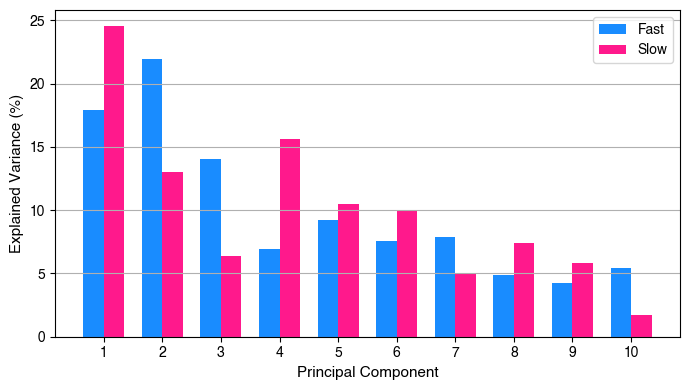

 Top 2 PCs with biggest fast vs slow difference (Fast - Slow):
  PC2: Δ = 8.97% (↑ Fast)
  PC4: Δ = -8.67% (↑ Slow)

 Top 10 signals contributing to PC2 (Turn1):
  LT Torso-Pelvic Axial (deg): 2.6711
  LT Torso-Pelvic Flexion Lat (deg): 2.6591
  LT Shoulder Rotation Ext (deg): 2.6510
  RT Ankle Abduction (deg): 2.6412
  RT Cervical Flexion Lat (deg): 2.6327
  RT Cervical Axial (deg): 2.6280
  LT Wrist Flexion (deg): 2.6244
  LT Wrist Radial (deg): 2.6242
  LT Knee Rotation Ext (deg): 2.6239
  RT Ankle Dorsiflexion (deg): 2.6152

 Top 10 signals contributing to PC4 (Turn1):
  LT Hip Rotation Ext (deg): 2.7240
  LT Hip Flexion (deg): 2.6980
  LT Hip Abduction (deg): 2.6925
  LT Knee Abduction (deg): 2.6623
  LT Shoulder Flexion (deg): 2.6586
  LT Shoulder Abduction Hrz (deg): 2.6477
  LT Torso-Pelvic Flexion Lat (deg): 2.6464
  LT Wrist Flexion (deg): 2.6457
  RT Ankle Abduction (deg): 2.6419
  LT Wrist Radial (deg): 2.6410


In [28]:
turn_segments, turn_run_names = extract_turns(data, turns) # Extract resampled turn data from the raw dataset
pca_analysis(turn_segments, turn_run_names, run_speed_labels, selected_turn="Turn1") # Perform PCA analysis

In [40]:
"""
Plot the mean values of selected biomechanical signals for 'fast' and 'slow' runs within a specific turn.
"""

def plot_single_signal_per_turn(turn_name, signal, all_data, run_labels,
                                 n_fast=5, n_slow=5,
                                 marker_col='Marker', time_col='time',
                                 show_std=True, show_title=True):
    # Use Helvetica font
    mpl.rcParams['font.family'] = 'Helvetica'

    fast_data = []
    slow_data = []
    min_len = float('inf')
    durations = {}

    # Compute durations for run filtering
    for run_name, df in all_data.items():
        if run_name not in run_labels:
            continue
        if marker_col not in df.columns or time_col not in df.columns:
            continue
        try:
            t0 = df[df[marker_col] == f"{turn_name} start"][time_col].values[0]
            t1 = df[df[marker_col] == f"{turn_name} finish"][time_col].values[0]
            if t0 < t1:
                durations[run_name] = t1 - t0
        except IndexError:
            continue

    if len(durations) < (n_fast + n_slow):
        print(f"⚠️ Not enough valid runs for turn '{turn_name}' (found {len(durations)}, need at least {n_fast + n_slow})")
        return

    sorted_runs = sorted(durations.items(), key=lambda x: x[1])
    top_fast = set(r for r, _ in sorted_runs[:n_fast])
    top_slow = set(r for r, _ in sorted_runs[-n_slow:])

    # Collect signal data for top fast and slow runs
    for run_name, df in all_data.items():
        if run_name not in top_fast and run_name not in top_slow:
            continue
        if signal not in df.columns:
            continue
        try:
            t0 = df[df[marker_col] == f"{turn_name} start"][time_col].values[0]
            t1 = df[df[marker_col] == f"{turn_name} finish"][time_col].values[0]
            segment = df[(df[time_col] >= t0) & (df[time_col] <= t1)]
            segment_resampled = np.interp(
                np.linspace(0, 1, 100),
                np.linspace(0, 1, len(segment)),
                segment[signal].values
            )
            min_len = min(min_len, len(segment_resampled))
            if run_name in top_fast:
                fast_data.append(segment_resampled)
            elif run_name in top_slow:
                slow_data.append(segment_resampled)
        except Exception as e:
            print(f"⚠️ Error with run {run_name}: {e}")
            continue

    if not fast_data or not slow_data:
        print(f"⚠️ No valid values to plot for {signal} in {turn_name}")
        return

    # Compute mean and SEM
    fast_trimmed = [x[:min_len] for x in fast_data]
    slow_trimmed = [x[:min_len] for x in slow_data]
    mean_fast = np.mean(fast_trimmed, axis=0)
    mean_slow = np.mean(slow_trimmed, axis=0)
    sem_fast = np.std(fast_trimmed, axis=0) / np.sqrt(len(fast_trimmed))
    sem_slow = np.std(slow_trimmed, axis=0) / np.sqrt(len(slow_trimmed))
    x_vals = np.linspace(0, 100, min_len)

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(x_vals, mean_fast, label="Fast (±SD)", color='#0080ff', linewidth=2)
    plt.plot(x_vals, mean_slow, label="Slow (±SD)", color='#ff0080', linewidth=2)

    if show_std:
        plt.fill_between(x_vals, mean_fast - sem_fast, mean_fast + sem_fast, color='#0080ff', alpha=0.1)
        plt.fill_between(x_vals, mean_slow - sem_slow, mean_slow + sem_slow, color='#ff0080', alpha=0.1)

    plt.xlabel("Normalized Time / %", fontsize=12)
    plt.ylabel("Angle / deg", fontsize=12)

    if show_title:
        signal_clean = signal.replace("(deg)", "").strip()
        plt.title(f"{signal_clean} – {turn_name}", fontsize=13, pad=15)

    plt.legend(loc="upper left")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.locator_params(axis='y', nbins=7)
    plt.tight_layout()
    plt.show()


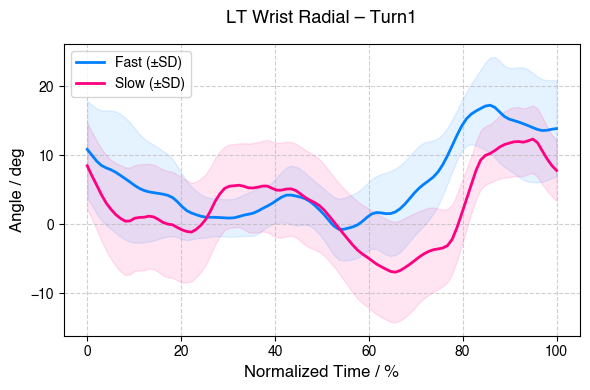

In [41]:
plot_single_signal_per_turn(turn_name="Turn1", signal = "LT Wrist Radial (deg)", all_data=data, run_labels=run_speed_labels)